
<span style="color:red"># **Project In Progress: Updated 9/22/2022**</span>

# Introduction


## Motivation:

Social media subgroups that focus on trading tend to be filled with poor analysis and a lack of due diligince. More sophisticated investors and traders tend to create groups on forumns and websites where there is a barrier to entry in order to ensure quality in discusion and analysis. Even with this reality, large sub groups on social media sites like reddit's wall street bets have, in the past, been able to move prices in the equity markets based on the sheer number of participants involnved in group think on the website. If we can gain insight using natural language processing to gauge sentiment on forums like this one, we may then be able to identify mis-priced derivatves based on our price and volume projections coupled with implied and historical volatitly on the contracts themselves. If we beleive that the sentiment will influence future prices a certain way, we may be able to momentum trade the derivatives contracts, opening positions on contracts that we belive to be mispriced based on our assumtions and projections of future volatility. 

This introduction will be updated as the project continues accordingly:

1. Sentiment analysis of stock market related reddit forumns
2. Derivatives pricing math (framework for pricing) and assumptions needed to determine 'mis-pricing'
3. APIs used 

# Part 1: Sentiment Analysis 

## Using the Reddit API to develope a sentiment analysis dashboard - Tickers mentioned and pos / neg sentiment 

In [1]:
# Laod libraries and packages

import numpy as np
import pandas as pd
import requests
import json
import os
import dotenv
import sys
from IPython import display
import math
from pprint import pprint
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
sys.tracebacklimit = 0 # turn off the error tracebacks


## Part 1a:
### Connect to reddit API

In [2]:
# API request relevent information 

# Create variables for keys and access token from .env file

import dotenv

dotenv.load_dotenv()

secret = os.getenv('client_secret')

client = os.getenv('client_id')

user = os.getenv('user_agent')


In [3]:
# Request reddit API using PRAW 

import praw

reddit = praw.Reddit(client_id = client,
                     client_secret = secret,
                     user_agent = user)

headlines = []

## Part 1b:
### Headlines: Gather headlines from stock market related subreddits - 'Wallstreetbets'.'TheWallStreet', 'TradeVol'

In [4]:
def get_headlines(subreddit):
    
    """
    This function will request and download the appropriate headlines from the 
    neccesary API object from above
    
    Input:
    
    Subreddit name (str) to retrieve headlines from
    """
    
    global reddit
    global headlines
    
    for submission in reddit.subreddit(subreddit).new(limit=None):
        headlines.append(submission.title)
        display.clear_output()
        #print(len(headlines),'headlines found')
    return headlines

In [5]:
# Call functions and save dataframes

wsb = get_headlines('wallstreetbets')
wst = get_headlines('TheWallStreet')
tv = get_headlines('TradeVol')


In [6]:
# Download vader lexicon package from natural language toolkit used below

#import nltk
#nltk.download('vader_lexicon')


In [7]:
# Update vader lexicon dictionary with new words we want to look for
# plus their sentiment scores

from nltk.sentiment.vader import SentimentIntensityAnalyzer

new_words = {
    'call': 3.0,
    'put': -3.0,
    'bullish': 3.0,
    'bearish': -3.0,
    'bull': 3.0,
    'bear': -3.0,
    'puts': -3.0,
    'calls': 3.0,
    'moon': 3.0,
    'crash': -3.0
}

SIA = SentimentIntensityAnalyzer()

SIA.lexicon.update(new_words)

In [8]:
def get_sentiment(text):
    
    """
    This function will create a Sentiment Intensity Analyzer,
    analyze the headlines or comments input, and generate a sentiment score
    for each. The scores range from negative,neutral, to positive. The 
    compund output inicates a range from -1 to 1, or, extremely 
    negative to extremely positive. The thresholds for where these
    compund sentiments are cut off will be set below
    
    """
    from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
    
    sia = SIA()
    results = []
    
    for line in text:
        pol_score = sia.polarity_scores(line)
        pol_score['headline'] = line
        results.append(pol_score)
        df = pd.DataFrame(results)
        df['label'] = 0
        df.loc[df['compound'] > 0.2, 'label'] = 1
        df.loc[df['compound'] < -0.2, 'label'] = -1
        df = df[['headline', 'label']]
    return df
    

In [9]:

# Run sentiment analysis on the headlines and save to dataframes

wsb_df = get_sentiment(wsb)
wst_df = get_sentiment(wst)
tv_df = get_sentiment(tv)

df_list = [wsb_df,wst_df,tv_df]

In [10]:
def check_headlines(df_list):
    
    """ This function will print pos and neg headlines 
    so we can check to make sure our SIA works properly
    (development purposes only)"""
    
    for df in df_list:
        print("Positive headlines:\n")
        pprint(list(df[df['label'] == 1].headline)[:5], width=200)

        print("\nNegative headlines:\n")
        pprint(list(df[df['label'] == -1].headline)[:5], width=200)
        

In [11]:
# check_headlines(df_list)

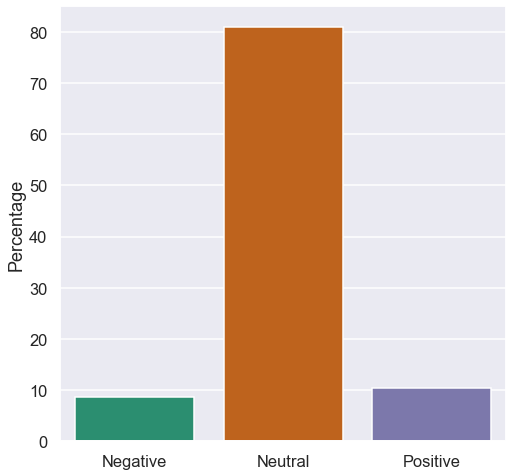

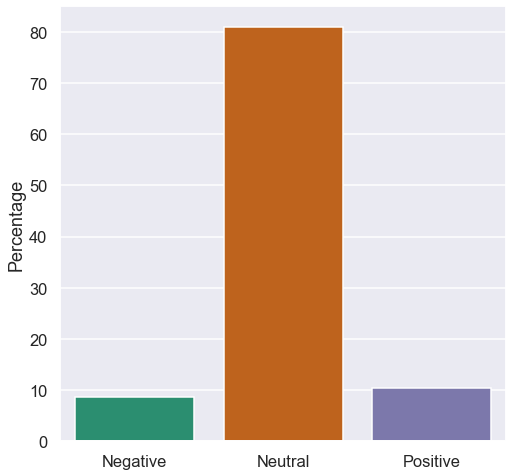

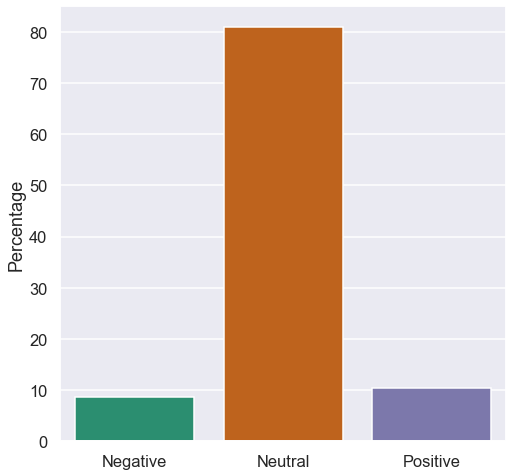

In [14]:
# Plot overall sentiment 

for df in df_list:

    fig, ax = plt.subplots(figsize=(8, 8))

    counts = df.label.value_counts(normalize=True) * 100

    sns.barplot(x=counts.index, y=counts, ax=ax)

    ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
    ax.set_ylabel("Percentage")

    plt.show()

We can see that the SIA is not performing optimally, we need to parse the hedlines and add words to the vader lexicon dictionary in order to properly identify community slang, and trading terms as either positive or negative. Based on the headlines available, many of the posts are not serious, are sarcastic, or unrelated to true market dynamics. We need to account for this going forward, and only include posts that have at least a semi serious discussion around them. This problem is specific to the wallstreetbets subredit, as it is known to be a less serious community. TheWallStreet and TradeVol will likely have higher quality data. Similarly, the amount of neutral ratings we have in our data is not reflective of true neitrality in the headlines. We also need to include comments on the posts into our analysis. 

## Part 1c:
### Gather comments from certain posts and analyze sentiment